<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/UDOP/Fine_tune_UDOPEncoderModel_on_FUNSD_(HuggingFace_Trainer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune UDOP, encoder-only, on the FUNSD dataset

[UDOP](https://huggingface.co/docs/transformers/main/en/model_doc/udop) is an exciting document AI model by Microsoft Research. It consists of a vision encoder and a text decoder, similar to models like [Donut](https://huggingface.co/docs/transformers/en/model_doc/donut) and [Pix2Struct](https://huggingface.co/docs/transformers/model_doc/pix2struct). It's a generative model, where we first encode the document image into embeddings, which are then used to condition a text-decoder (GPT-like) to generate the text we want, like structured JSON.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/udop_architecture.jpg"
alt="drawing" width="600"/>

<small> UDOP architecture. Taken from the <a href="https://arxiv.org/abs/2212.02623">original paper.</a> </small>

However, one could also simply use the encoder-only part of UDOP, add a linear classifier on top, and fine-tune it altogether on a labeled dataset, very much like how one would train a BERT, LayoutLMv2 or LayoutLMv3 model. That's what we're going to do in this notebook! This is useful in case we don't require the generative part of UDOP.

## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 191396, done.
remote: Counting objects: 100% (977/977), done.
remote: Compressing objects: 100% (552/552), done.
remote: Total 191396 (delta 519), reused 726 (delta 370), pack-reused 190419
Receiving objects: 100% (191396/191396), 166.91 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (141488/141488), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 883.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets seqeval sentencepiece accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [ ]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd-layoutlmv3 downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

Let's check the features:

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

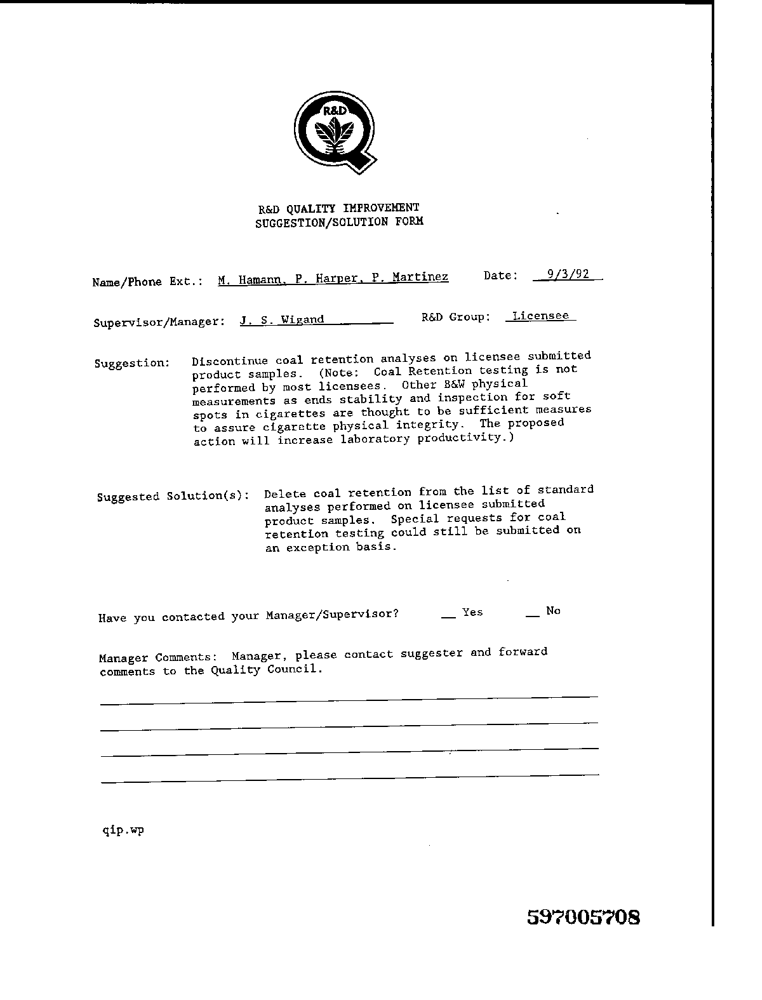

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'performed', 'on', 'licen

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `UdopProcessor`, which internally wraps a `UdopImageProcessor` (for the image modality) and a `UdopTokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [ ]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load UdopProcessor behind the scenes,
# based on the checkpoint we provide from the hub
# we specify apply_ocr=False here as we already have used an OCR engine
processor = AutoProcessor.from_pretrained("microsoft/udop-large", apply_ocr=False)

We'll first create `id2label` and label2id mappings, useful for inference. Note that `UdopForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [ ]:
print(id2label)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}


Next, we'll define a function which we can apply on the entire dataset.

In [ ]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><pad><

Next, we set the format to PyTorch.

In [ ]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><pad><

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  if label.item() != -100:
    print(processor.tokenizer.decode([id]), id2label[label.item()])
  else:
    print(processor.tokenizer.decode([id]), label.item())

R O
& -100
D -100
 B-QUESTION
: -100
Su B-QUESTION
g -100
gestion -100
: -100
Date B-QUESTION
: -100
License B-ANSWER
e -100
Yes B-QUESTION
No B-QUESTION
 O
59 -100
700 -100
57 -100
08 -100
R B-HEADER
& -100
D -100
Q I-HEADER
UAL -100
ITY -100
 I-HEADER
IM -100
PRO -100
V -100
EMENT -100
S I-HEADER
UG -100
GES -100
TION -100
/ -100
SO I-HEADER
LU -100
TION -100
 I-HEADER
FORM -100
Name B-QUESTION
 I-QUESTION
/ -100
Phone I-QUESTION
Ex I-QUESTION
t -100
. -100
 I-QUESTION
: -100
M B-ANSWER
. -100
Ha I-ANSWER
mann -100
P I-ANSWER
. -100
Harper I-ANSWER
, -100
P I-ANSWER
. -100
Martinez I-ANSWER
9 B-ANSWER
/ -100
 I-ANSWER
3/ -100
 I-ANSWER
92 -100
R B-QUESTION
& -100
D -100
Group I-QUESTION
: -100
J B-ANSWER
. -100
S I-ANSWER
. -100
Wi I-ANSWER
g -100
and -100
Supervisor B-QUESTION
 I-QUESTION
/ -100
Manager I-QUESTION
Dis B-ANSWER
continu -100
e -100
coal I-ANSWER
retention I-ANSWER
analyses I-ANSWER
on I-ANSWER
license I-ANSWER
e -100
submitted I-ANSWER
product I-ANSWER
samples I-ANSWE

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-20-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

Also note the warning we get when loading the weights: it is telling us that all the weights of UDOP's decoder aren't used, which is expected as we're only using the encoder part.

In [ ]:
from transformers import UdopEncoderModel, UdopPreTrainedModel, UdopConfig
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn

class UdopForTokenClassification(UdopPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.udop = UdopEncoderModel.from_pretrained("microsoft/udop-large")
    self.num_labels = config.num_labels

    self.dropout = nn.Dropout(0.5)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, input_ids, bbox, attention_mask, pixel_values, labels):
    outputs = self.udop(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, pixel_values=pixel_values)
    sequence_output = outputs[0]

    seq_length = input_ids.shape[1]
    # only take the text part of the output representations
    sequence_output = outputs[0][:, :seq_length]
    sequence_output = self.dropout(sequence_output)

    logits = self.classifier(sequence_output)

    loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

config = UdopConfig(id2label=id2label, label2id=label2id)
model = UdopForTokenClassification(config)

Some weights of the model checkpoint at nielsr/udop-large were not used when initializing UdopEncoderModel: ['decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.block.16.layer.1.EncDecAttention.q.weight', 'decoder.block.1.layer.2.DenseReluDense.wi.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.2.layer.1.EncDecAttention.q.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.2.DenseReluDense.wo.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.9.layer.0.layer_norm.weight', 'decoder.block.19.layer.2.DenseReluDense.wi.weight', 'decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.8.layer.1.layer_norm.weight', 'decoder.block.18.layer.1.EncDecAttention.k.we

## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=3000,
                                  warmup_ratio=0.1,
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,
                                  gradient_accumulation_steps=8,
                                  eval_accumulation_steps=8,
                                  learning_rate=5e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Train the model

Let's train!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,1.577256,0.370475,0.402246,0.385707,0.488029
200,No log,0.728565,0.734486,0.845840,0.786240,0.764395
300,No log,0.696579,0.813422,0.872384,0.841872,0.796440
400,No log,0.834695,0.828458,0.852986,0.840543,0.779742
500,0.775400,0.912845,0.846730,0.865748,0.856133,0.794966
600,0.775400,0.948970,0.856354,0.870342,0.863291,0.796808
700,0.775400,1.021489,0.837970,0.876468,0.856786,0.798772
800,0.775400,1.033358,0.854094,0.878509,0.866130,0.805034
900,0.775400,1.123953,0.853659,0.857580,0.855615,0.799509


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


## Evaluate the model

NOTE: we end up with an F1 score of about 90%. Here's what I got on a typical run:

```
Step	Training Loss	Validation Loss	Precision	Recall	F1	Accuracy
100	No log	0.725903	0.812686	0.837162	0.824742	0.781338
200	No log	0.807471	0.814045	0.840225	0.826928	0.782320
300	No log	0.856688	0.812919	0.867279	0.839220	0.799632
400	No log	0.995948	0.839463	0.862175	0.850667	0.795089
500	0.178400	0.994649	0.825769	0.863706	0.844311	0.798649
600	0.178400	1.012888	0.844751	0.874936	0.859579	0.808349
700	0.178400	1.057748	0.835127	0.871363	0.852860	0.806262
800	0.178400	1.069149	0.840730	0.870342	0.855280	0.803560
900	0.178400	1.103710	0.845274	0.867279	0.856135	0.802455
1000	0.039800	1.107941	0.844246	0.868811	0.856352	0.802947
```
Compared to LayoutLMv3:
```
Step	Training Loss	Val Loss	Precision	Recall	F1	Accuracy
100	  No log	  0.716025	0.752040	0.824143	0.786442	0.780459
200	  No log	  0.584986	0.828558	0.876304	0.851762	0.801973
300	  No log	  0.525926	0.859583	0.900149	0.879398	0.833947
400	  No log	  0.492821	0.881413	0.904620	0.892866	0.854630
500	  0.561200	0.528126	0.858382	0.885246	0.871607	0.852490
600	  0.561200	0.547107	0.888023	0.906110	0.896976	0.847973
700	  0.561200	0.555438	0.887338	0.915549	0.901222	0.859384
800	  0.561200	0.582942	0.881471	0.905117	0.893137	0.854749
900	  0.561200	0.599762	0.891051	0.910084	0.900467	0.852015
1000	0.133400	0.608207	0.887222	0.910581	0.898750	0.847855
````

However, this score cannot be directly compared to LayoutLM and LayoutLMv2, as LayoutLMv3 employs so-called **segment position embeddings** (inspired by [StructuralLM](https://arxiv.org/abs/2105.11210)). This means that several tokens that belong to the same "segment" (let's say, an address) get the same bounding box coordinates, and in return the same 2D position embeddings.

This is also mentioned in the paper:
>  Note that LayoutLMv3 and StructuralLM use segment-level layout positions, while the other works use word-level layout positions. The use of segment-level positions may benefit the semantic entity labeling task on FUNSD [25], so the two types of work are not directly comparable.

In [ ]:
trainer.evaluate()

## Inference

You can load the model for inference as follows:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

Let's take an example of the training dataset to show inference.

In [ ]:
example = dataset["test"][0]
print(example.keys())

We first prepare it for the model using the processor.

In [ ]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

The model outputs logits of shape (batch_size, seq_len, num_labels).

In [ ]:
logits = outputs.logits
logits.shape

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [ ]:
labels = encoding.labels.squeeze().tolist()
print(labels)

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).